## Sanjay Santokee - sanjay.santokee@my.uwi.edu


#### Imports

In [1]:
%pylab inline
import numpy as np
import sklearn.linear_model as linear
import sklearn.model_selection as selection
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import metrics

import torch as th
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd 


Populating the interactive namespace from numpy and matplotlib


#### Reading in Data

In [2]:
df = pd.read_csv('wdbc.data', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


#### Cleaning data and Sorting to Input and Target Arrays

In [3]:
x = [] # input (attributes)
y = [] # output (targets)

x = df.iloc[:, 2:32].values
y = df.iloc[:, 1].values

x = MinMaxScaler().fit_transform(x)
y = LabelEncoder().fit_transform(y)

#### Setting up Models for Neural Network

In [4]:
class MoonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.BCELoss()
        
    def forward(self, x):
        return None 
    
    def loss(self, x, y):
        probs = self.forward(x)
        return self.loss_func(probs, y)
    
    def predict_proba(self, x, as_numpy=False):
        res = self.forward(x)
        if as_numpy:
            res = res.detach().numpy()
        return res
    
    def predict(self, x, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(x, as_numpy)
        return probs > threshold
    
    def fit(self, x, y, epochs=1000, lr=0.1, lam=0):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        loss_curve = []
        for _ in range(epochs):
            optimizer.zero_grad()
            loss_val = self.loss(x, y) + self.regularize(lam)
            loss_curve.append(loss_val.data.item())
            loss_val.backward()
            optimizer.step()
        return loss_curve
    
    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [5]:
class NNModel(MoonModel):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(30, 15, bias=True)
        self.act1 = nn.Tanh()
        self.l2 = nn.Linear(15, 1, bias=True)
        self.act2 = nn.Sigmoid()
        
    def get_intermediary(self, x):
        res = self.l1(x)
        res = self.act1(res)
        return res
        
    def forward(self, x):
        res = self.l1(x)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)
        return res    
    

#### Applying Logistic Regression and Neural Network Model

In [6]:
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(x)

f1_lr = []
f1_nn = [] 

def plot_loss(loss_curve):
    plt.plot(list(range(len(loss_curve))), loss_curve)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lr = linear.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    probs = lr.predict_proba(X_test)[:,1]
    f1_lr.append(metrics.f1_score(y_test, predictions))
    
    X_train = th.tensor(X_train, dtype=th.float32)
    X_test = th.tensor(X_test, dtype=th.float32)
    y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)
    
    nn1 = NNModel()
    curve = nn1.fit(X_train, y_train, lam=0.01)
    
    predictions = nn1.predict(X_test, as_numpy=True)
    probs = nn1.predict_proba(X_test, as_numpy=True)
    f1_nn.append(metrics.f1_score(y_test, predictions))    

#### Comparing Statistical Results for the Models

In [7]:
print("Logistic Regression Model Mean: ", np.mean(f1_lr))
print("Logistic Regression Model Standard Deviation: ", np.std(f1_lr))

Logistic Regression Model Mean:  0.9545660516667087
Logistic Regression Model Standard Deviation:  0.030638211445220047


In [8]:
print("Neural Network Model Mean: ", np.mean(f1_nn))
print("Neural Network Model Standard Deviation: ", np.std(f1_nn))

Neural Network Model Mean:  0.9421653546621398
Neural Network Model Standard Deviation:  0.01946538695917698


In [9]:
print("T-Test comparing the Logistic Regression and the Neural Network Models: ")
print(stats.ttest_rel(f1_lr, f1_nn))

T-Test comparing the Logistic Regression and the Neural Network Models: 
Ttest_relResult(statistic=1.0278105430851017, pvalue=0.36212659580406836)


Using a significance level of 0.05, we see that the difference between logistic regression 
and neural network are not statistically significant.

#### Intermediary Workings of the Neural Network

In [10]:
X_transformed = th.tensor(x, dtype=th.float32) 
representations = nn1.get_intermediary(X_transformed) 
representations = representations.detach().numpy() 

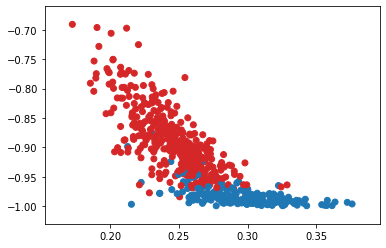

In [11]:
colors = np.array(['tab:red' if cl == 0 else 'tab:blue' for cl in y])
plt.scatter(representations[:,0], representations[:,1], c=colors)